In [21]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad
from matplotlib import colors
import uproot
import scipy.stats as st

Here we select the configuration:

In [22]:
fit_func_name = "MBPWL" # Function to fit. Possible options "MBPWL" (concave multiply broken power-law), "PWL" (Power-law), "LP" (concave Log-Parabola), "freeLP (Log-Parabola without concavity constraint)#Maybie more will be added in the future
Telescope = "CTAN_alpha" # Telescope to simulate. Possible options: "CTA_alpha", "MAGIC" (MAGIC does not work propperly yet)
Spectrum_func_name = "PWL" #Function for the simulated spectrum. POssible options: "PWL" , "LP" will be added soon but its not yet implemented.
EBL_Model = "Dominguez" #EBL model to test. Only "Dominguez" (Domínguez et al. 2011) is available at the moment.
Source_flux = 8.70e-6 # f0 flux of the source. Should be in m−2  s−1  TeV−1
Observation_time = 42480 #Observation time in seconds
niter = 1000 #number of iterations for the chi^2 vs alpha plot #The niter=1 has a different plot (just give it a try)


#for the chi² vs alpha plot:
initial_guess_pos = 1.5 #recommended values for MBPWL (>1.), for LP (<1.) (the chi² for alpha=initial_guess_pos if much worse than the other ones, will be fixed soon), for PWL (>1.)
step = 0.05
last_bin = 2
first_bin = 0.

#for PWL Spectrum function
if Spectrum_func_name == "PWL":
    Norm = 0.25 #Normalization Energy in TeV (Default 0.25)
    Ph_index = 2.03 #photon index for the power law (Default 2.03)

#for MBPWL as fit_function
if fit_func_name == "MBPWL":
    knots = 3 #Number of knots of the function. 3 is the default.
    initial_guess_0 = np.array([5e-7, 0, 0, 0, 0]) #initial guess of the MBPWL parameters: phi_0, lam1, deltas (len(deltas)=knots-2))
#for PWL
elif fit_func_name == "PWL":
    initial_guess_0 = np.array([5e-7, 2.]) #phi_0, gamma
#for LP and freeLP
elif fit_func_name == "LP" or fit_func_name == "freeLP":
    initial_guess_0 = np.array([5e-7, 2., 1.]) #phi_0, alpha, beta

Here we define some functions used with all the configurations:

In [23]:
def chisq(obs, exp, error):
    return np.sum(np.square(obs - exp) / np.square(error))
    
def Gauss(E, A, mu, sigma):
    return A * (np.exp(-1/2 * np.square((E - mu) / sigma)) / (sigma * np.sqrt(2*np.pi)))

def Gauss_int(A, mu, sigma, Em, Ep):
    return quad(Gauss, Em, Ep, args=(A, mu, sigma)) #maybie some mistake here because of log scale


def log_interp1d(E_before, y_before, E_after):
    interp_func = interpolate.interp1d(np.log10(E_before), np.log10(y_before), bounds_error=False, fill_value = "extrapolate", kind='linear')
    interpolated = np.power(10 ,interp_func(np.log10(E_after)))
    return interpolated

def normal_interp1d(E_before, y_before, E_after):
    interp_func = interpolate.interp1d(E_before, y_before, bounds_error=False, fill_value = "extrapolate", kind='linear')
    interpolated = interp_func(E_after)
    return interpolated

And now we define the function and minimization depending on the previously selected fit function:

In [24]:
if fit_func_name == "MBPWL":
    def fit_func(xdata, params):
        if knots < 2 or knots > 30: #change this when adding more number of knots
            raise Exception('knots have to be larger or equal than 3 and smaller than 30')
        else:
            polw = np.zeros(len(xdata))
            Ebr = np.geomspace(xdata[0], xdata[-1], knots+2)[1:-1]
            gamma = np.zeros(knots+1)
            phi = np.zeros(knots+1)
            phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
            gamma0 = params[1]
            sqrtdelta_gamma = params[2:knots+2]
            delta_gamma = np.square(sqrtdelta_gamma)
            gamma[0] = gamma0
            phi[0] = phi_0
            for i in range(knots):
                gamma[i+1] = gamma[i] + delta_gamma[i]
                phi[i+1] = phi[i] * Ebr[i] ** delta_gamma[i]
            for i in range(len(xdata)):
                for j in range(knots):
                    if xdata[i]<Ebr[0]:
                        polw[i] = phi[0] * xdata[i] ** (-gamma[0])
                    elif Ebr[-1] < xdata[i]:
                        polw[i] = phi[-1] * xdata[i] ** (-gamma[-1])
                    elif Ebr[j] <= xdata[i] < Ebr[j+1]:
                        polw[i] = phi[j+1] * xdata[i] ** (-gamma[j+1])
        return polw

elif fit_func_name == "PWL":
    def fit_func(xdata, params):
        phi = params[0]
        gamma = params [1]
        PLW = phi * xdata ** (-gamma)
        return PLW

elif fit_func_name == "LP":
    def fit_func(xdata, params):
        phi0 = params[0]
        alpha = params[1]
        beta = params[2]
        #Enorm = 1TeV #if it is 1 TeV no need ot include it (if it is different, need to add it to te LP function)
        LP = phi0 * (xdata) ** (alpha - beta * beta * np.log(xdata))
        return LP

elif fit_func_name == "freeLP":
    def fit_func(xdata, params):
        phi0 = params[0]
        alpha = params[1]
        beta = params[2]
        #Enorm = 1TeV #if it is 1 TeV no need ot include it (if it is different, need to add it to te LP function)
        LP = phi0 * (xdata) ** (alpha - beta * np.log(xdata))
        return LP


else:
    raise Exception('The function "{func}" has not been implemented.'.format(func = fit_func_name))

def LSQ(params):
    return np.sum((ydata - fit_func(xdata, params)) ** 2 / ydata_u ** 2)

def fit(initial_guess):
    #print('Warning: the shape of the parametes will depend on the number of knots (defined as knots)')
    #print('Warning: this will give the parameters of the fit and its errors which have to be put into the multiple_bpl function in order to get the fit')
    LSQ.errordef = Minuit.LIKELIHOOD

    m = Minuit(LSQ, initial_guess)
    #m.limits["initial_guess[2:-1]"] = (0,None)
    m.tol = 1e-20

    m.migrad()
    # print(m.values)

    m.hesse()
    # print(m.errors)

    return m

Now let's load the EBL model

In [25]:
if EBL_Model == "Dominguez":
    file = np.loadtxt('tau_dominguez11.out')
    pdfile = pd.DataFrame(file)
    pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})
    E_EBL = pdfile['E [TeV]'].to_numpy()
    tau_EBL = pdfile['tau z=0.20842105'].to_numpy()
else:
    raise Exception('The EBL model "{func}" has not been implemented.'.format(func = EBL_Model))

Now we define the simulated spectrum function:

In [26]:
if Spectrum_func_name == "PWL":
    def dNdE_absorbed(K, E, Norm, Ph_index):
        dNdE = K / ((E/Norm)**Ph_index)
        m_tau = -tau_EBL
        return dNdE * np.exp(m_tau)

elif Spectrum_func_name == "LP":
    print("Not yet implemented")

else:
    raise Exception('The simulated spectrum "{func}" has not been implemented.'.format(func = Spectrum_func_name))

Now we load and treat the telescope performance files depending on the selected telescope:

In [27]:
if Telescope == "CTAN_alpha":
    
    #Effective area:
    fileEA = np.loadtxt('EffArea50h.txt', skiprows = 11)
    EffA = pd.DataFrame(fileEA)
    EffA = EffA.rename(columns={ 0 : 'E [TeV]', 1: 'Eff area (m^2)'})
    EffaE= EffA['E [TeV]'].to_numpy()
    Effa = EffA['Eff area (m^2)'].to_numpy()

    # Effa_reb = np.zeros(len(E_EBL[2:37]))
    # for i in range(len(E_EBL[2:37])):
    #     for j in range(len(EffaE[9:51])):
    #         if EffaE[j+9] < E_EBL[i+2] and EffaE[j+10] > E_EBL[i+2]:
    #             m = (Effa[j+10]-Effa[j+9])/(EffaE[j+10]-EffaE[j+9])
    #             n = Effa[j+9] - m * EffaE[j+9]
    #             Effa_reb[i] = m * E_EBL[i+2] + n

    Effa_reb = normal_interp1d(EffaE, Effa, E_EBL[2:37])


    #Anglular resolution:
    fileAng = np.loadtxt('Angres.txt', skiprows = 11)
    Angresall = pd.DataFrame(fileAng)
    Angresall = Angresall.rename(columns={ 0 : 'E [TeV]', 1: 'Angular resolution (deg)'})
    AngresE = Angresall['E [TeV]'].to_numpy()
    Angres = Angresall['Angular resolution (deg)'].to_numpy()
    logE = np.log10(E_EBL)

    # logAngres = np.log10(Angres)
    # logAngresE = np.log10(AngresE)
    # logAngres_reb = np.zeros(len(E_EBL[2:37]))
    # for i in range(len(E_EBL[2:37])):
    #     for j in range(len(AngresE[1:-1])):
    #         if logAngresE[j+1] < logE[i+2] and logAngresE[j+2] > logE[i+2]:
    #             m = (logAngres[j+2]-logAngres[j+1])/(logAngresE[j+2]-logAngresE[j+1])
    #             n = logAngres[j+1] - m * logAngresE[j+1]
    #             logAngres_reb[i] = m * logE[i+2] + n
    # Angres_reb = 10**logAngres_reb

    Angres_reb = log_interp1d(AngresE, Angres, E_EBL[2:37])

    #Background:
    fileBkg = np.loadtxt('Bkg50h.txt', skiprows = 10)
    Bkgpd = pd.DataFrame(fileBkg)
    Bkgpd = Bkgpd.rename(columns={ 0 : 'E_min (TeV)', 1: 'E_max (TeV)', 2: 'Bck Rate (Hz/deg^2)'})

    BckgEmin = Bkgpd['E_min (TeV)'].to_numpy()
    BckgEmax = Bkgpd['E_max (TeV)'].to_numpy()
    Bckg = Bkgpd['Bck Rate (Hz/deg^2)'].to_numpy()
    BckgEdiff = BckgEmax - BckgEmin

    BckgElogmean = np.power(10 ,np.mean([np.log10(BckgEmax), np.log10(BckgEmin)], axis = 0))

    Ebinsmin = np.zeros(len(E_EBL))
    Ebinsmax = np.zeros(len(E_EBL))

    for i in range(1, len(E_EBL)):
        Ebinsmin[i] = 10**(np.mean([np.log10(E_EBL[i]), np.log10(E_EBL[i-1])]))
    for i in range(len(E_EBL) - 1):
        Ebinsmax[i] = 10**(np.mean([np.log10(E_EBL[i]), np.log10(E_EBL[i+1])]))
        
    Ebinsmin[0] = 10**(np.log10(Ebinsmin[1])-(np.log10(Ebinsmin[2])-np.log10(Ebinsmin[1])))
    Ebinsmax[len(E_EBL)-1] = 10**(np.log10(Ebinsmax[len(E_EBL)-2])-(np.log10(Ebinsmax[len(E_EBL)-3])-np.log10(Ebinsmax[len(E_EBL)-2])))
    Ebinsw = Ebinsmax - Ebinsmin
    DifBckg = Bckg / (BckgEmax - BckgEmin) #Hz/deg**2

    def log_interp1d2(xx, yy):
        logx = np.log10(xx)
        logy = np.log10(yy)
        interp = interpolate.interp1d(logx, logy, fill_value='extrapolate', kind='slinear')
        log_interp = lambda zz: np.power(10.0, interp(np.log10(zz)))
        return log_interp

    interpolation_bckg = log_interp1d2(BckgElogmean,DifBckg)

    Bckg_reb = np.zeros([len(E_EBL[2:37]),2])
    for i in range(len(E_EBL[2:37])):
        Bckg_reb[i] = quad(interpolation_bckg, Ebinsmin[i+2], Ebinsmax[i+2])
    Bckg_reb = Bckg_reb[:,0]

    #Energy Resolution:
    fileEres = np.loadtxt('Eres.txt', skiprows = 8)
    Eresall = pd.DataFrame(fileEres)
    Eresall = Eresall.rename(columns={ 0 : 'E [TeV]', 1: 'Energy resolution (deg)'})
    EresE = Eresall['E [TeV]'].to_numpy()
    Eres = Eresall['Energy resolution (deg)'].to_numpy()

    # logEres = np.log10(Eres)
    # logEresE = np.log10(EresE)

    # logEres_reb = np.zeros(len(E_EBL[2:37]))
    # for i in range(len(E_EBL[2:37])):
    #     for j in range(len(EresE[0:-1])):
    #         if logEresE[j] < logE[i+3] and logEresE[j+1] > logE[i+3]:
    #             m = (logEres[j+1]-logEres[j])/(logEresE[j+1]-logEresE[j])
    #             n = logEres[j] - m * logEresE[j]
    #             logEres_reb[i] = m * logE[i+3] + n
    # Eres_reb = 10**logEres_reb
    # Eres_reb2 = Eres_reb * E_EBL[2:37]

    Eres_reb = log_interp1d(EresE[:-1], Eres[:-1], E_EBL[2:37])
    Eres_reb2 = Eres_reb * E_EBL[2:37]

    #Treating the data:
    def degtorad(ang):
        return ang * np.pi / 180


    skyang = (180/np.pi)**2 * 2 * np.pi * (1-np.cos(degtorad(Angres_reb)))#deg^2
    bckgmu = Bckg_reb * Observation_time * skyang

    ##Generating dNdE_absorved and applying Eres to it
    dNdEa = dNdE_absorbed(Source_flux, E_EBL, Norm, Ph_index)
    mu_vec = dNdEa[2:37] * Effa_reb * Ebinsw[2:37] * Observation_time


    logEbins = np.zeros(len(E_EBL[2:37])+1)
    for i in range(len(E_EBL[2:37])+1):
        if i == 0:
            logEbins[i] = logE[2] - ((logE[3]-logE[2])/2)
        elif i == (len(E_EBL[2:37])):
            logEbins[i] = logE[2:37][i-1] + ((logE[2:37][i-1]-logE[2:37][i-2])/2)
        else:
            logEbins[i] = (logE[2:37][i] + logE[2:37][i-1]) / 2

    Ebins = 10 ** logEbins

    mu_vec_reco = np.zeros(len(mu_vec))
    mu_vec_i = np.zeros(len(mu_vec))

    for i in range(len(mu_vec)):
        for j in range(len(mu_vec)):
            A = mu_vec[i]
            B = bckgmu[i]
            Em = Ebins[j]
            Ep = Ebins[j+1]
            sigma = Eres_reb2[i]
            mu = E_EBL[2:37][i]

            mu_vec_i[j] = Gauss_int(A, mu, sigma, Em, Ep)[0]
        mu_vec_reco = mu_vec_reco + mu_vec_i
    E_final = E_EBL[7:33]
    mu_vec_final = mu_vec_reco[5:-4]
    bckgmu_final = bckgmu[5:-4]
    Effa_final = Effa_reb[5:-4]
    Ebinsw_final = Ebinsw[7:33]
    tau = tau_EBL[7:33]

elif Telescope == "MAGIC":
    print("MAGIC not implemented yet")

else:
    raise Exception('The telescope "{func}" has not been implemented.'.format(func = Telescope))

In [28]:
if niter == 1:
    my_generator = np.random.default_rng(2021)
    Simbckg1 = my_generator.poisson(bckgmu_final)
    # Simbckg1 = Simbckg1.astype(float)
    # for i in range(len(Simbckg1)):
    #     if Simbckg1[i] == 0:
    #         Simbckg1[i] = bckgmu[i]
    Simbckg1_u = np.sqrt(Simbckg1)
    Simbckg5 = my_generator.poisson(5*bckgmu_final)/5
    # Simbckg5 = Simbckg5.astype(float)
    # for i in range(len(Simbckg5)):
    #     if Simbckg5[i] == 0:
    #         Simbckg5[i] = bckgmu[i]
    Simbckg5_u = np.sqrt(Simbckg5)

    N = my_generator.poisson(mu_vec_final)
    # N = mu

    # for i in range(len(N)):
    #     if N[i] == 0:
    #         N[i] = mu[i]
    N_u = np.sqrt(N)

    NpB = np.around(N + Simbckg1 - Simbckg5).astype(int)
    NpB_u = N_u + Simbckg1_u - Simbckg5_u

    dNdE_b = NpB / Effa_final / Ebinsw_final / Observation_time
    dNdE_b_u = NpB_u / Effa_final / Ebinsw_final / Observation_time

    SED = np.square(E_final) * dNdE_b
    SED_u = np.square(E_final) * dNdE_b_u

    ydata = SED
    xdata = E_final
    ydata_u = SED_u
    things = fit(initial_guess=initial_guess_0)

    Egam = np.geomspace(E_final[1],E_final[-1], 300)

    plt.plot(Egam, fit_func(Egam, things.values), label='concave fit', color = 'orange')
    plt.errorbar(xdata, ydata, label='MC data',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
    plt.title("MC data and fit for EBL absorved spectrum")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r"$E$ ($TeV$)")
    plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
    plt.legend()
    plt.show()

    chisqs = []

    alphas1 = np.arange(initial_guess_pos + step, last_bin + step, step)
    alphas2 = np.arange(initial_guess_pos, first_bin - step, -step)
    alphas = np.append(alphas1, alphas2)

    if fit_func_name == "MBPWL":
        initial_guess_mat = np.zeros((len(alphas)+1, knots+2))
    elif fit_func_name == "PWL":
        initial_guess_mat = np.zeros((len(alphas)+1, 2))
    elif fit_func_name == "LP":
        initial_guess_mat = np.zeros((len(alphas)+1, 3))
    initial_guess_mat[0] = things.values #phi_0, lam1, deltas (len(deltas)=knots))

    for i in range(len(alphas)):
        alpha = alphas[i]
        #print("alpha = ", alpha)
        dNdE2 = dNdE_b * np.exp(alpha*tau)
        dNdE2_u = dNdE_b_u * np.exp(alpha*tau)
        SED2 = np.square(E_final) * dNdE2
        SED_u2 = np.square(E_final) * dNdE2_u
        ydata = SED2
        xdata = E_final
        ydata_u = SED_u2
        initial_guess = initial_guess_mat[i] #phi_0, lam1, deltas (len(deltas)=knots))
        if alpha == initial_guess_pos:
            initial_guess = initial_guess_mat [0]
        things = fit(initial_guess=initial_guess)
        if i < (len(alphas)):
            initial_guess_mat[i+1] = things.values
        chi2 = chisq(SED2, fit_func(E_final, things.values), SED_u2)
        chisqs.append(chi2)

        # if alpha == 1 or alpha == 0.15 or alpha == 0.9 or alpha == 1.:  #This is used to plot the data+ the fit when there is some alpha value we need to see.
        #     plt.plot(xdata, fit_func(xdata, things.values), label='concave fit', color = 'orange')
        #     plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
        #     plt.xscale('log')
        #     plt.yscale('log')
        #     plt.xlabel(r"$E$ ($TeV$)")
        #     plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
        #     plt.legend()
        #     plt.show()

    plt.plot(alphas, chisqs, 'o')
    plt.yscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\chi^2$')
    plt.show()
    order = np.argsort(alphas)
    interpx = np.arange(first_bin, last_bin, step/5)
    alphas_reord = np.take_along_axis(alphas, order, axis=0)
    chisqs_reord = np.take_along_axis(np.array(chisqs), order, axis=0)
    f1 = interpolate.interp1d(alphas_reord, chisqs_reord, kind='linear')
    chis_new = f1(interpx)
    sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
    upper_bound_1s = step/5 * np.max(sigma_inter_1s)
    lower_bound_1s = step/5 * np.min(sigma_inter_1s)
    print("The minimum is at alpha = ", interpx[np.argmin(chis_new)], " + ", upper_bound_1s-interpx[np.argmin(chis_new)], " - ", interpx[np.argmin(chis_new)] - lower_bound_1s)
    sigma_inter_2s = np.where(chis_new <= 4 + np.min(chis_new))
    upper_bound_2s = step/5 * np.max(sigma_inter_2s)
    lower_bound_2s = step/5 * np.min(sigma_inter_2s)
    print("The 2 sigma interval is at alpha = ", interpx[np.argmin(chis_new)], " + ", upper_bound_2s-interpx[np.argmin(chis_new)], " - ", interpx[np.argmin(chis_new)] - lower_bound_2s)
    sigma_inter_3s = np.where(chis_new <= 9 + np.min(chis_new))
    upper_bound_3s = step/5 * np.max(sigma_inter_3s)
    lower_bound_3s = step/5 * np.min(sigma_inter_3s)
    print("The 3 sigma interval is at alpha = ", interpx[np.argmin(chis_new)], " + ", upper_bound_3s-interpx[np.argmin(chis_new)], " - ", interpx[np.argmin(chis_new)] - lower_bound_3s)
      
else:
    chisqs_iter = []
    alphas_iter = []

    for j in range(niter):
        my_generator = np.random.default_rng(j)
        Simbckg1 = my_generator.poisson(bckgmu_final)
        # Simbckg1 = Simbckg1.astype(float)
        # for i in range(len(Simbckg1)):
        #     if Simbckg1[i] == 0:
        #         Simbckg1[i] = bckgmu[i]
        Simbckg1_u = np.sqrt(Simbckg1)
        Simbckg5 = my_generator.poisson(5*bckgmu_final)/5
        # Simbckg5 = Simbckg5.astype(float)
        # for i in range(len(Simbckg5)):
        #     if Simbckg5[i] == 0:
        #         Simbckg5[i] = bckgmu[i]
        Simbckg5_u = np.sqrt(Simbckg5)

        N = my_generator.poisson(mu_vec_final)

        for i in range(len(N)): #this is used to avoid crashing when dividing by 0.
            if N[i] == 0:
                N[i] = 1
        N_u = np.sqrt(N)

        NpB = np.around(N + Simbckg1 - Simbckg5).astype(int)
        NpB_u = N_u + Simbckg1_u - Simbckg5_u

        dNdE_b = NpB / Effa_final / Ebinsw_final / Observation_time  #not strictly correct after energy migration
        dNdE_b_u = NpB_u / Effa_final/ Ebinsw_final / Observation_time

        SED = np.square(E_final) * dNdE_b
        SED_u = np.square(E_final) * dNdE_b_u

        chisqs = []
        # alphas = np.arange(0,2.05,0.05) #if you want to change the alpha values
        alphas1 = np.arange(initial_guess_pos + step, last_bin + step, step)
        alphas2 = np.arange(initial_guess_pos, first_bin - step, -step)
        alphas = np.append(alphas1, alphas2)

        alpha = initial_guess_pos
        dNdE2 = dNdE_b * np.exp(alpha*tau)
        dNdE2_u = dNdE_b_u * np.exp(alpha*tau)
        SED2 = np.square(E_final) * dNdE2
        SED_u2 = np.square(E_final) * dNdE2_u
        ydata = SED2
        xdata = E_final
        ydata_u = SED_u2
        things = fit(initial_guess=initial_guess_0)

        if fit_func_name == "MBPWL":
            initial_guess_mat = np.zeros((len(alphas)+1, knots+2))
        elif fit_func_name == "PWL":
            initial_guess_mat = np.zeros((len(alphas)+1, 2))
        elif fit_func_name == "LP":
            initial_guess_mat = np.zeros((len(alphas)+1, 3))
        initial_guess_mat[0] = things.values #phi_0, lam1, deltas (len(deltas)=knots))

        for i in range(len(alphas)):
            alpha = alphas[i]
            #print("alpha = ", alpha)
            dNdE2 = dNdE_b * np.exp(alpha*tau)
            dNdE2_u = dNdE_b_u * np.exp(alpha*tau)
            SED2 = np.square(E_final) * dNdE2
            SED_u2 = np.square(E_final) * dNdE2_u
            ydata = SED2
            xdata = E_final
            ydata_u = SED_u2

            initial_guess = initial_guess_mat[i] #phi_0, lam1, deltas (len(deltas)=knots))
            if alpha == initial_guess_pos:
                initial_guess = initial_guess_mat [0]
            things = fit(initial_guess=initial_guess)
            if i < (len(alphas)):
                initial_guess_mat[i+1] = things.values
            chi2 = chisq(SED2, fit_func(E_final, things.values), SED_u2)
            chisqs.append(chi2)
            # if alpha == 1.5 and j == 1:# or alpha == 0.15 or alpha == 0.9 or alpha == 1.:
            #     print(chi2)
            #     plt.plot(xdata, multiple_bpl(xdata, things.values), label='concave fit', color = 'orange')
            #     plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
            #     plt.xscale('log')
            #     plt.yscale('log')
            #     plt.xlabel(r"$E$ ($TeV$)")
            #     plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
            #     plt.legend()
            #     plt.show() 

        alphas_iter.append(alphas)
        chisqs_iter.append(chisqs)
        print("\033[2;31;43m iteration {iter} of {niter} finished \033[0;0m".format(iter = j+1, niter = niter))

 iteration 1 of 1000 finished 
 iteration 2 of 1000 finished 
 iteration 3 of 1000 finished 
 iteration 4 of 1000 finished 
 iteration 5 of 1000 finished 
 iteration 6 of 1000 finished 
 iteration 7 of 1000 finished 
 iteration 8 of 1000 finished 
 iteration 9 of 1000 finished 
 iteration 10 of 1000 finished 
 iteration 11 of 1000 finished 
 iteration 12 of 1000 finished 
 iteration 13 of 1000 finished 


/tmp/ipykernel_9570/3724736773.py:18: RuntimeWarning: overflow encountered in double_scalars
  phi[i+1] = phi[i] * Ebr[i] ** delta_gamma[i]
/tmp/ipykernel_9570/3724736773.py:24: RuntimeWarning: invalid value encountered in double_scalars
  polw[i] = phi[-1] * xdata[i] ** (-gamma[-1])


 iteration 14 of 1000 finished 
 iteration 15 of 1000 finished 
 iteration 16 of 1000 finished 
 iteration 17 of 1000 finished 
 iteration 18 of 1000 finished 
 iteration 19 of 1000 finished 
 iteration 20 of 1000 finished 


/tmp/ipykernel_9570/3724736773.py:26: RuntimeWarning: overflow encountered in double_scalars
  polw[i] = phi[j+1] * xdata[i] ** (-gamma[j+1])
/tmp/ipykernel_9570/3724736773.py:26: RuntimeWarning: invalid value encountered in double_scalars
  polw[i] = phi[j+1] * xdata[i] ** (-gamma[j+1])


 iteration 21 of 1000 finished 
 iteration 22 of 1000 finished 
 iteration 23 of 1000 finished 
 iteration 24 of 1000 finished 
 iteration 25 of 1000 finished 
 iteration 26 of 1000 finished 
 iteration 27 of 1000 finished 
 iteration 28 of 1000 finished 
 iteration 29 of 1000 finished 
 iteration 30 of 1000 finished 
 iteration 31 of 1000 finished 
 iteration 32 of 1000 finished 
 iteration 33 of 1000 finished 
 iteration 34 of 1000 finished 
 iteration 35 of 1000 finished 
 iteration 36 of 1000 finished 
 iteration 37 of 1000 finished 
 iteration 38 of 1000 finished 
 iteration 39 of 1000 finished 
 iteration 40 of 1000 finished 
 iteration 41 of 1000 finished 
 iteration 42 of 1000 finished 
 iteration 43 of 1000 finished 
 iteration 44 of 1000 finished 
 iteration 45 of 1000 finished 
 iteration 46 of 1000 finished 
 iteration 47 of 1000 finished 
 iteration 48 of 1000 finished 
 iteration 49 of 1000 finished 
 iteration 50 of 1000 finished 
 iteration 51 of 1000 finished 
 iterati

/tmp/ipykernel_9570/3724736773.py:22: RuntimeWarning: overflow encountered in double_scalars
  polw[i] = phi[0] * xdata[i] ** (-gamma[0])


 iteration 65 of 1000 finished 
 iteration 66 of 1000 finished 
 iteration 67 of 1000 finished 
 iteration 68 of 1000 finished 
 iteration 69 of 1000 finished 
 iteration 70 of 1000 finished 
 iteration 71 of 1000 finished 
 iteration 72 of 1000 finished 
 iteration 73 of 1000 finished 
 iteration 74 of 1000 finished 
 iteration 75 of 1000 finished 
 iteration 76 of 1000 finished 
 iteration 77 of 1000 finished 
 iteration 78 of 1000 finished 
 iteration 79 of 1000 finished 
 iteration 80 of 1000 finished 
 iteration 81 of 1000 finished 
 iteration 82 of 1000 finished 
 iteration 83 of 1000 finished 
 iteration 84 of 1000 finished 
 iteration 85 of 1000 finished 
 iteration 86 of 1000 finished 
 iteration 87 of 1000 finished 
 iteration 88 of 1000 finished 
 iteration 89 of 1000 finished 
 iteration 90 of 1000 finished 
 iteration 91 of 1000 finished 
 iteration 92 of 1000 finished 
 iteration 93 of 1000 finished 
 iteration 94 of 1000 finished 
 iteration 95 of 1000 finished 
 iterati

/tmp/ipykernel_9570/3724736773.py:59: RuntimeWarning: overflow encountered in square
  return np.sum((ydata - fit_func(xdata, params)) ** 2 / ydata_u ** 2)
/tmp/ipykernel_9570/3724736773.py:59: RuntimeWarning: overflow encountered in true_divide
  return np.sum((ydata - fit_func(xdata, params)) ** 2 / ydata_u ** 2)


 iteration 190 of 1000 finished 
 iteration 191 of 1000 finished 
 iteration 192 of 1000 finished 
 iteration 193 of 1000 finished 
 iteration 194 of 1000 finished 
 iteration 195 of 1000 finished 
 iteration 196 of 1000 finished 
 iteration 197 of 1000 finished 
 iteration 198 of 1000 finished 
 iteration 199 of 1000 finished 
 iteration 200 of 1000 finished 


/tmp/ipykernel_9570/3724736773.py:18: RuntimeWarning: invalid value encountered in double_scalars
  phi[i+1] = phi[i] * Ebr[i] ** delta_gamma[i]


 iteration 201 of 1000 finished 
 iteration 202 of 1000 finished 
 iteration 203 of 1000 finished 
 iteration 204 of 1000 finished 
 iteration 205 of 1000 finished 
 iteration 206 of 1000 finished 
 iteration 207 of 1000 finished 
 iteration 208 of 1000 finished 
 iteration 209 of 1000 finished 
 iteration 210 of 1000 finished 
 iteration 211 of 1000 finished 
 iteration 212 of 1000 finished 
 iteration 213 of 1000 finished 
 iteration 214 of 1000 finished 
 iteration 215 of 1000 finished 
 iteration 216 of 1000 finished 
 iteration 217 of 1000 finished 
 iteration 218 of 1000 finished 
 iteration 219 of 1000 finished 
 iteration 220 of 1000 finished 
 iteration 221 of 1000 finished 
 iteration 222 of 1000 finished 
 iteration 223 of 1000 finished 
 iteration 224 of 1000 finished 
 iteration 225 of 1000 finished 
 iteration 226 of 1000 finished 
 iteration 227 of 1000 finished 
 iteration 228 of 1000 finished 
 iteration 229 of 1000 finished 
 iteration 230 of 1000 finished 
 iteration

/tmp/ipykernel_9570/3724736773.py:24: RuntimeWarning: overflow encountered in double_scalars
  polw[i] = phi[-1] * xdata[i] ** (-gamma[-1])


 iteration 653 of 1000 finished 
 iteration 654 of 1000 finished 
 iteration 655 of 1000 finished 
 iteration 656 of 1000 finished 
 iteration 657 of 1000 finished 
 iteration 658 of 1000 finished 
 iteration 659 of 1000 finished 
 iteration 660 of 1000 finished 
 iteration 661 of 1000 finished 
 iteration 662 of 1000 finished 
 iteration 663 of 1000 finished 
 iteration 664 of 1000 finished 
 iteration 665 of 1000 finished 
 iteration 666 of 1000 finished 
 iteration 667 of 1000 finished 
 iteration 668 of 1000 finished 
 iteration 669 of 1000 finished 
 iteration 670 of 1000 finished 
 iteration 671 of 1000 finished 
 iteration 672 of 1000 finished 
 iteration 673 of 1000 finished 
 iteration 674 of 1000 finished 
 iteration 675 of 1000 finished 
 iteration 676 of 1000 finished 
 iteration 677 of 1000 finished 
 iteration 678 of 1000 finished 
 iteration 679 of 1000 finished 
 iteration 680 of 1000 finished 
 iteration 681 of 1000 finished 
 iteration 682 of 1000 finished 
 iteration

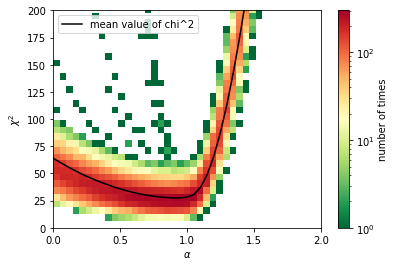

A 53.4 \% of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum
A 86.9 \% of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum
A 99.0 \% of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum
The median minimum is at alpha =  0.9  +  0.09  -  0.13


In [30]:
#use this only if niter different to 1:
if niter == 1:
    raise Warning("You don't need this with 1 iteration")
else:
    chisqs_iter = np.array(chisqs_iter)
    alphas_iter = np.array(alphas_iter)
    alphas_iter2 = np.concatenate(alphas_iter)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
    chisqs_iter2 = np.concatenate(chisqs_iter)
    order = np.argsort(alphas_iter[0])


    fig, ax = plt.subplots()
    ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0), color = "black", label="mean value of chi^2")
    h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=[len(alphas_iter[0]),300], norm = colors.LogNorm(), cmap = "RdYlGn_r", label="histogram of chi^2 values")
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\chi^2$')
    ax.legend()
    ax.set_ylim(0,200)
    # ax.set_xlim(0.5,1.15)
    fig.colorbar(h[3], ax=ax, label="number of times")
    plt.show()

    sigma_1 = []
    sigma_2 = []
    sigma_3 = []
    s1 = 0
    s2 = 0
    s3 = 0
    for i in range(len(alphas_iter)):
        sigma_1_0 = np.where(chisqs_iter[i] <= 1 + np.min(chisqs_iter[i]))
        sigma_2_0 = np.where(chisqs_iter[i] <= 4 + np.min(chisqs_iter[i]))
        sigma_3_0 = np.where(chisqs_iter[i] <= 9 + np.min(chisqs_iter[i]))
        sigma_1.append(sigma_1_0)
        sigma_2.append(sigma_2_0)
        sigma_3.append(sigma_3_0)
        number = np.where(np.round(alphas, decimals = 2) == 1)
        if number in sigma_1_0[0]: #this number is the position of the alpha=1 inside the alhpas array
            s1 += 1
        if number in sigma_2_0[0]:
            s2 += 1
        if number in sigma_3_0[0]:
            s3 += 1
    # print(sigma_1)
    # print(sigma_2)
    # print(sigma_3)
    print("A {sig} \% of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum".format( sig = np.round(s1 / niter * 100, decimals = 2)))
    print("A {sig} \% of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum".format( sig = np.round(s2 / niter * 100, decimals = 2)))
    print("A {sig} \% of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum".format( sig = np.round(s3 / niter * 100, decimals = 2)))
    # print("The median minimum is at alpha={minimum}".format(minimum = alphas[np.argmin(np.median(chisqs_iter,0))]))

    order = np.argsort(alphas_iter[0])
    interpx = np.arange(first_bin, last_bin, step/5)
    alphas_reord = np.take_along_axis(np.median(alphas_iter, 0), order, axis=0)
    chisqs_repord = np.take_along_axis(np.median(chisqs_iter, 0), order, axis=0)
    f1 = interpolate.interp1d(alphas_reord, chisqs_repord, kind='linear')
    chis_new = f1(interpx)
    sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
    upper_bound_1s = step/5 * np.max(sigma_inter_1s)
    lower_bound_1s = step/5 * np.min(sigma_inter_1s)
    # print("The 1 sigma upper bound is: ", upper_bound_1s, "and the lower bound is: ", lower_bound_1s)
    print("The median minimum is at alpha = ", np.round(interpx[np.argmin(chis_new)], decimals = 2), " + ", np.round(upper_bound_1s-interpx[np.argmin(chis_new)], decimals = 4), " - ", np.round(interpx[np.argmin(chis_new)] - lower_bound_1s, decimals = 4))
